# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***INDUCED EMOTION DATA***

# **Goal 1: Long Form Analysis**
The initial Qualtrics data was pre-processed in a separate R script. For this part of the analysis, we will build on those dataframes and perform the following tasks:
1. Examination of Missing Data
2. Checking for Duplicates
3. Adding High-Level Summary Features
4. Looking at Mean Differences between Drug and Placebo
    * Overall means
    * Stimulus type (music, natural sounds, and speech)
    * Emotion type (positive, negative, neutral)
    * Arousal and valence levels
    
**We will do this separately for *induced* emotion data and *perceived* emotion data**

In [1]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, pandas_profiling, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind
from fancyimpute import KNN

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, cvxopt, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix
from imblearn.over_sampling import SMOTE

# visualization tools
import matplotlib.pyplot as plt, qgrid, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
from plotnine import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# View tab (Taken from Martin: https://stackoverflow.com/users/2575273/martin)
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))
files = os.listdir(os.curdir)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")
print(os.getcwd())

# only get warnings once
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)

# # toggle on/off code!
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Using TensorFlow backend.


/Users/home/Desktop/Research/Tylenol/Analysis


### Read in Data
Read in the data.

In [2]:
inducedLong = pd.read_csv('Fixed Induced.csv')
print("original inducedLong shape:", inducedLong.shape)

View(inducedLong.head().T)

original inducedLong shape: (4806, 33)


### Missing Data
We will delete observations with no ID or without a drug/placebo indication. We cannot use these observations for analysis.

In [3]:
# examine
null = inducedLong[inducedLong.isnull().any(axis=1)]
print("null shape:", null.shape) 
null.head(5).T

pd.DataFrame(inducedLong.isnull().sum())

# delete 'Other' column
inducedLong = inducedLong.drop(['Other'], axis=1)

# drop rows where there's no ID or drug/placebo information
inducedLong = inducedLong.dropna(subset=['FixedID', 'DrugCode', 'DrugPlacebo'], how='any')

print("new inducedLong shape:", inducedLong.shape)
View(pd.DataFrame(inducedLong.isnull().mean()*100))

null shape: (4557, 33)
new inducedLong shape: (4554, 32)


### Check for Duplicates
Duplicates would indicate an error with the participant ID number fed into the surveys on Qualtrics. These would lead to biased data, so we get rid of them. 

In [4]:
# Check number of induced stimuli
print("Number of Induced Stimuli: ", len(inducedLong['Stimulus'].unique()), "\n")

# Check max ID number
maxid = int(inducedLong['FixedID'].max())
    
# make dataframe checking the number of perceived/induced stimuli per person
participants = pd.DataFrame()
participants['Potential'] = pd.Series(range(1, maxid+1))
participants = participants.set_index('Potential')
participants['Induced'] = inducedLong[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])

# where are the errors?
iError = list(participants[participants['Induced'] > len(inducedLong['Stimulus'].unique())].index)
print("induced errors in stimuli: ", iError, "\n")

View(inducedLong[inducedLong['FixedID'].isin(iError)])

# delete all IDs who are in error
    # it must be due to some kind of coding mistake or mistake with Qualtrics entries
drop = inducedLong[inducedLong['FixedID'].isin(iError)].index
inducedLong.drop(drop, inplace=True)

# check
print("fixed inducedLong shape:", inducedLong.shape, "\n")

participants['InducedFixed'] = inducedLong[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
iErrorCheck = list(participants[participants['InducedFixed'] > len(inducedLong['Stimulus'].unique())].index)
print("induced errors in stimuli: ", iErrorCheck, "\n")
View(participants)

Number of Induced Stimuli:  18 

induced errors in stimuli:  [55, 91, 92, 117, 133, 172] 

fixed inducedLong shape: (4338, 32) 

induced errors in stimuli:  [] 



### Add summary columns
We want to differentiate blunting effects between ***Positive*** and ***Negative*** stimuli, across ***Music***, ***Speech***, and ***Natural Sounds***, and by ***Arousal and Valence*** scores.

We will add a new column to summarize each of these features based on emotional theory and *a priori* stimulus analysis.

In [5]:
# PosNeg: Positive or Negative Emotions
posneg = [
    (inducedLong['Stimulus'].str.contains('Negative|Sad|Fear', regex=True) == True),
    (inducedLong['Stimulus'].str.contains('Positive|Happy|Tender', regex=True) == True)]
choices = ['Negative', 'Positive']
inducedLong['PosNeg'] = np.select(posneg, choices, default='Neutral')

# SoundType: Music, Speech, Natural Sounds
sound = [
    (inducedLong['Stimulus'].str.contains('Music', regex=True) == True),
    (inducedLong['Stimulus'].str.contains('Speech', regex=True) == True)]
choices = ['Music', 'Speech']
inducedLong['SoundType'] = np.select(sound, choices, default='Natural Sounds')
    # note though: no speech in induced

# Russell: Circumplex model info
russell = [
    (inducedLong['Stimulus'].str.contains('Negative-Valence Low|Sad', regex=True) == True),
    (inducedLong['Stimulus'].str.contains('Negative-Valence High|Fear', regex=True) == True),
    (inducedLong['Stimulus'].str.contains('Positive-Valence Low|Tender', regex=True) == True),
    (inducedLong['Stimulus'].str.contains('Positive-Valence High|Happy', regex=True) == True)]
choices = ['Neg-Valence Low-Arousal', 'Neg-Valence High-Arousal', 'Pos-Valence Low-Arousal', 'Pos-Valence High-Arousal']
inducedLong['Russell'] = np.select(russell, choices, default='Neutral')

# Crosstabs
pd.crosstab(index = inducedLong['Stimulus'], columns = inducedLong['PosNeg'])
pd.crosstab(index = inducedLong['Stimulus'], columns = inducedLong['Russell'])
pd.crosstab(index = inducedLong['Stimulus'], columns = inducedLong['SoundType'])

SoundType,Music,Natural Sounds
Stimulus,,
Fear Music 1,241,0
Fear Music 2,241,0
Happy Music 1,241,0
Happy Music 2,241,0
Negative-Valence High-Arousal Human,0,241
Negative-Valence High-Arousal Non-human,0,241
Negative-Valence Low-Arousal Human,0,241
Negative-Valence Low-Arousal Non-human,0,241
Neutral Human,0,241


### Comparing Means Between Drug/Placebo
Now we can compare means in ***perceived*** emotion ratings in drug and placebo conditions.

We prep the data like we did above.

In [6]:
# Change values for easy interpretation
inducedLong['DrugPlacebo'].replace(0, "Placebo", inplace=True)
inducedLong['DrugPlacebo'].replace(1, "Drug", inplace=True)

# Make arrays for t-tests
placebo = inducedLong[inducedLong['DrugPlacebo']=="Placebo"]
drug = inducedLong[inducedLong['DrugPlacebo']=="Drug"]

inducedLong.sample(2)

,FixedID,DrugCode,DrugPlacebo,Locus,Stimulus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,PosNeg,SoundType,Russell
546,5.0,5J,Placebo,Induced,Sad Music 1,4.0,2.0,Not Measured,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,Negative,Music,Neg-Valence Low-Arousal
4753,213.0,15D2,Drug,Induced,Positive-Valence Low-Arousal Non-human,2.0,6.0,Not Measured,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive,Natural Sounds,Pos-Valence Low-Arousal


#### *Overall Means*
We examine the overall mean scores for *positive emotion ratings*, *negative emotion ratings*, and *arousal ratings* for participants who took the drug vs. participants who took the placebo.

**We then compare the means using t-tests.**

In [7]:
from scipy.stats import t

In [8]:
# Positive Emotion Ratings
print("Induced Emotion Overall Means -- Positive")
print("means:", inducedLong.groupby(['DrugPlacebo'])['Positive'].mean().round(2), "\n")
print("std dev:", inducedLong.groupby(['DrugPlacebo'])['Positive'].std().round(2), "\n")
df = inducedLong.groupby(['DrugPlacebo'])['Positive'].count().sum()-2
print("degrees of freedom:", df, "\n")
alpha = 0.05
#print("critical value:", t.ppf(1.0 - alpha, df), "\n")

t, p = ttest_ind(placebo.dropna()['Positive'], drug.dropna()['Positive'])
print("t = " + str(t.round(2)))
print("p = " + str(p.round(5)))

Induced Emotion Overall Means -- Positive
means: DrugPlacebo
Drug       3.64
Placebo    3.72
Name: Positive, dtype: float64 

std dev: DrugPlacebo
Drug       3.41
Placebo    3.41
Name: Positive, dtype: float64 

degrees of freedom: 4236 

t = 0.74
p = 0.46102


In [9]:
# Negative Emotion Ratings
print("Induced Emotion Overall Means -- Negative")
print("means:", inducedLong.groupby(['DrugPlacebo'])['Negative'].mean().round(2), "\n")
print("std dev:", inducedLong.groupby(['DrugPlacebo'])['Negative'].std().round(2), "\n")
df = inducedLong.groupby(['DrugPlacebo'])['Negative'].count().sum()-2
print("degrees of freedom:", df, "\n")
alpha = 0.05
#print("critical value:", t.ppf(1.0 - alpha, df), "\n")

t, p = ttest_ind(placebo.dropna()['Negative'], drug.dropna()['Negative'])
print("t = " + str(t.round(2)))
print("p = " + str(p.round(5)))

Induced Emotion Overall Means -- Negative
means: DrugPlacebo
Drug       3.64
Placebo    3.56
Name: Negative, dtype: float64 

std dev: DrugPlacebo
Drug       3.39
Placebo    3.34
Name: Negative, dtype: float64 

degrees of freedom: 4236 

t = -0.78
p = 0.434


#### **Conclusion: There is no difference in induced emotion ratings for positive emotions or negative emotions between drug and placebo conditions.**


# *Stimulus Type (Music, Natural Sounds)*
Although there were no differences in the overall means between drug and placebo conditions, we will look at the mean induced emotion ratings across different stimulus types.

We will *not* conduct t-tests to prevent any potential problems of multiple tests.

### There are no speech stimuli for induced emotion

In [8]:
# Positive Emotion Ratings
print("Induced Emotion Stimulus Type -- Positive")
print(inducedLong.groupby(['DrugPlacebo', 'SoundType'])['Positive'].mean().round(2), "\n")

# Negative Emotion Ratings
print("Induced Emotion Stimulus Type -- Negative")
print(inducedLong.groupby(['DrugPlacebo', 'SoundType'])['Negative'].mean().round(2))

Induced Emotion Stimulus Type -- Positive
DrugPlacebo  SoundType     
Drug         Music             4.72
             Natural Sounds    2.78
Placebo      Music             4.57
             Natural Sounds    3.04
Name: Positive, dtype: float64 

Induced Emotion Stimulus Type -- Negative
DrugPlacebo  SoundType     
Drug         Music             3.14
             Natural Sounds    4.04
Placebo      Music             3.16
             Natural Sounds    3.89
Name: Negative, dtype: float64


#### *Graph Stimulus Type:* **Positive**

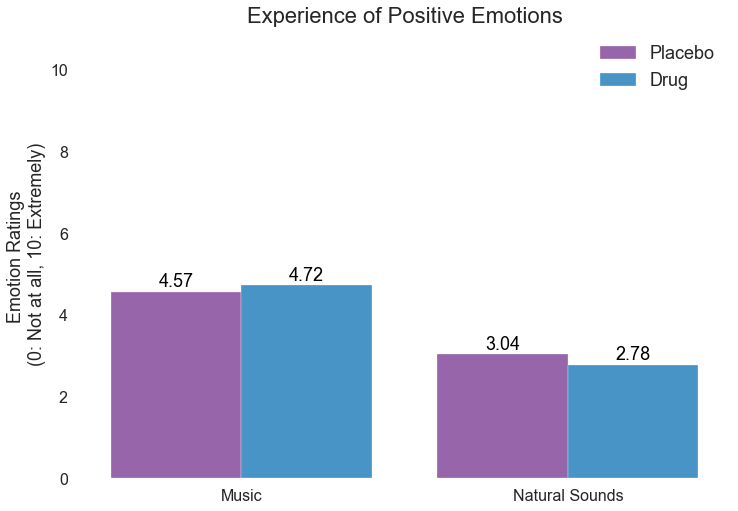

In [9]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Positive", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

#### *Graph Stimulus Type:* **Negative**
Now we can look at the attentuating effect of acetaminophen on perceived negative emotions.

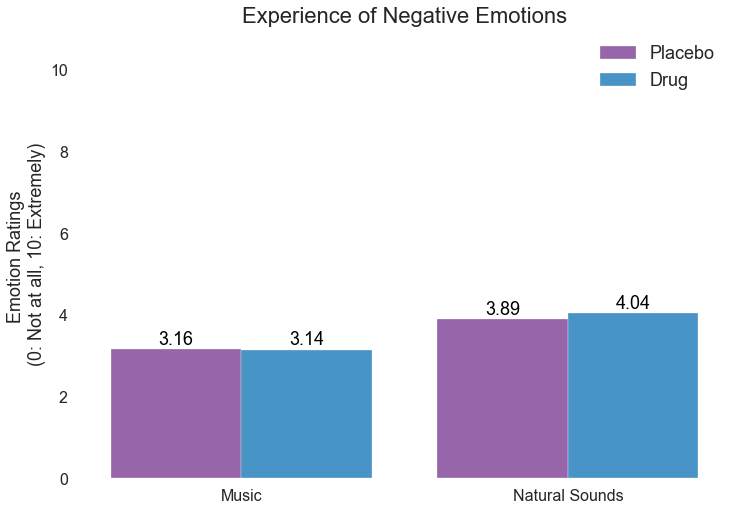

In [10]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Negative", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

### There are no arousal ratings for induced emotion

# *Emotion Type (Positive, Negative, Neutral)*
Next, we will look at the induced emotion ratings for positive stimuli, negative stimuli, and netural stimuli in both drug and placebo conditions.

In [11]:
# Positive Emotion Ratings
print("Induced Emotion Emotion Type -- Positive")
print(inducedLong.groupby(['DrugPlacebo', 'PosNeg'])['Positive'].mean().round(2), "\n")

# Negative Emotion Ratings
print("Induced Emotion Emotion Type -- Negative")
print(inducedLong.groupby(['DrugPlacebo', 'PosNeg'])['Negative'].mean().round(2))

Induced Emotion Emotion Type -- Positive
DrugPlacebo  PosNeg  
Drug         Negative    1.65
             Neutral     1.29
             Positive    6.22
Placebo      Negative    1.76
             Neutral     1.52
             Positive    6.23
Name: Positive, dtype: float64 

Induced Emotion Emotion Type -- Negative
DrugPlacebo  PosNeg  
Drug         Negative    5.88
             Neutral     3.85
             Positive    1.35
Placebo      Negative    5.78
             Neutral     3.60
             Positive    1.33
Name: Negative, dtype: float64


## *Circumplex Type (Arousal and Valence Info)*
We can look to see whether the drug attenuation affects perceived emotion ratings for different types of emotional stimuli:
* Negative Valence, High Arousal
* Negative Valence, Low Arousal
* Neutral
* Positive Valence, Low Arousal
* Positive Valence, High Arousal


In [12]:
# Positive Emotion Ratings
print("Induced Emotion Circumplex -- Positive")
print(inducedLong.groupby(['DrugPlacebo', 'Russell'])['Positive'].mean().round(2), "\n")

# Negative Emotion Ratings
print("Induced Emotion Circumplex -- Negative")    
print(inducedLong.groupby(['DrugPlacebo', 'Russell'])['Negative'].mean().round(2))

Induced Emotion Circumplex -- Positive
DrugPlacebo  Russell                 
Drug         Neg-Valence High-Arousal    1.43
             Neg-Valence Low-Arousal     1.86
             Neutral                     1.29
             Pos-Valence High-Arousal    6.84
             Pos-Valence Low-Arousal     5.60
Placebo      Neg-Valence High-Arousal    1.56
             Neg-Valence Low-Arousal     1.97
             Neutral                     1.52
             Pos-Valence High-Arousal    6.90
             Pos-Valence Low-Arousal     5.56
Name: Positive, dtype: float64 

Induced Emotion Circumplex -- Negative
DrugPlacebo  Russell                 
Drug         Neg-Valence High-Arousal    6.41
             Neg-Valence Low-Arousal     5.36
             Neutral                     3.85
             Pos-Valence High-Arousal    1.05
             Pos-Valence Low-Arousal     1.66
Placebo      Neg-Valence High-Arousal    6.27
             Neg-Valence Low-Arousal     5.30
             Neutral           

#### *Graph Circumplex:* **Positive**
Once again, a graph will help visualize this effect.

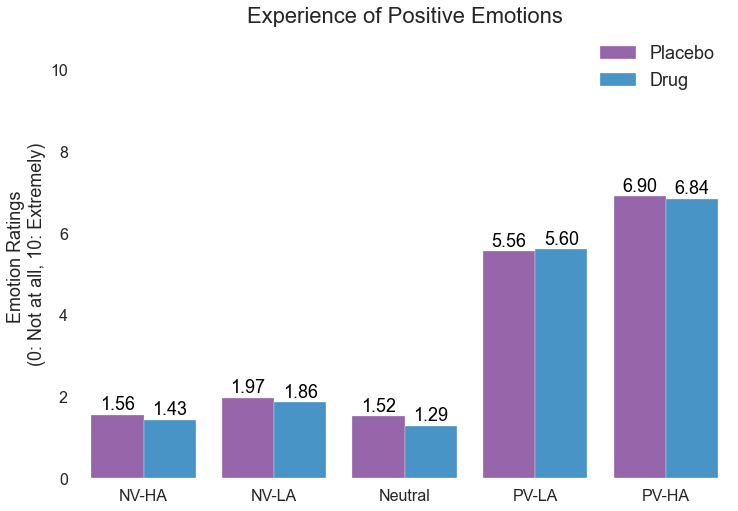

In [13]:
# change labels for easy interpretation
inducedLong['Russell'].replace("Neg-Valence High-Arousal", "NV-HA", inplace=True)
inducedLong['Russell'].replace("Pos-Valence High-Arousal", "PV-HA", inplace=True)
inducedLong['Russell'].replace("Neg-Valence Low-Arousal", "NV-LA", inplace=True)
inducedLong['Russell'].replace("Pos-Valence Low-Arousal", "PV-LA", inplace=True)

# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Positive", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

#### *Graph Circumplex:* **Negative**
And our last graph.

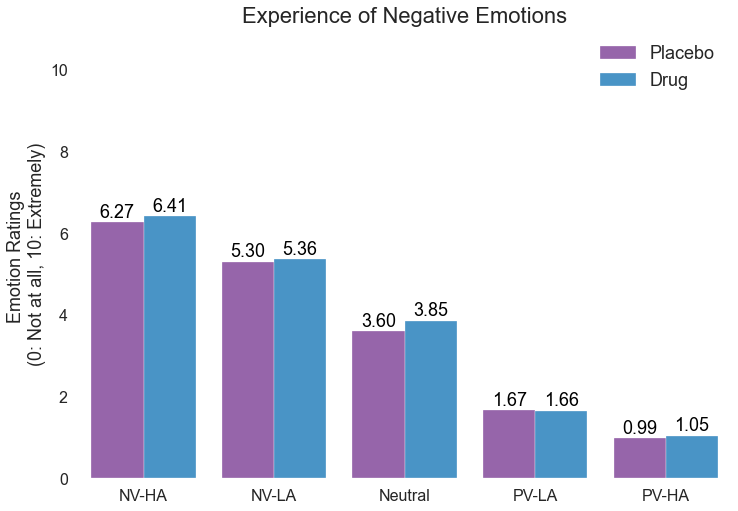

In [14]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Negative", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

# **Plot perceived emotions by sound type**

In [15]:
music = inducedLong[inducedLong['SoundType'] == "Music"]
natural = inducedLong[inducedLong['SoundType'] == "Natural Sounds"]
speech = inducedLong[inducedLong['SoundType'] == "Speech"]

## *Music*

In [16]:
musicEmotions = [
    (music['Stimulus'].str.contains('Tender', regex=True) == True),
    (music['Stimulus'].str.contains('Sad', regex=True) == True),
    (music['Stimulus'].str.contains('Happy', regex=True) == True),
    (music['Stimulus'].str.contains('Fear', regex=True) == True)]
choices = ['Tender', 'Sad', 'Happy', 'Fear']
music['Stimulus'] = np.select(musicEmotions, choices)

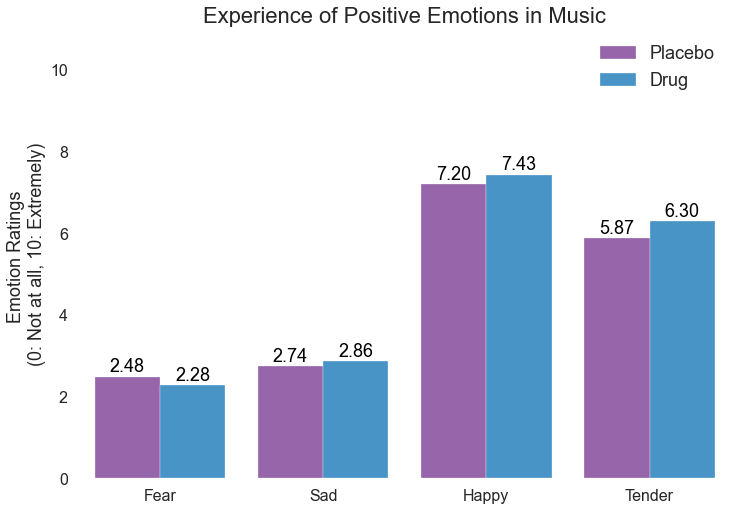

In [17]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

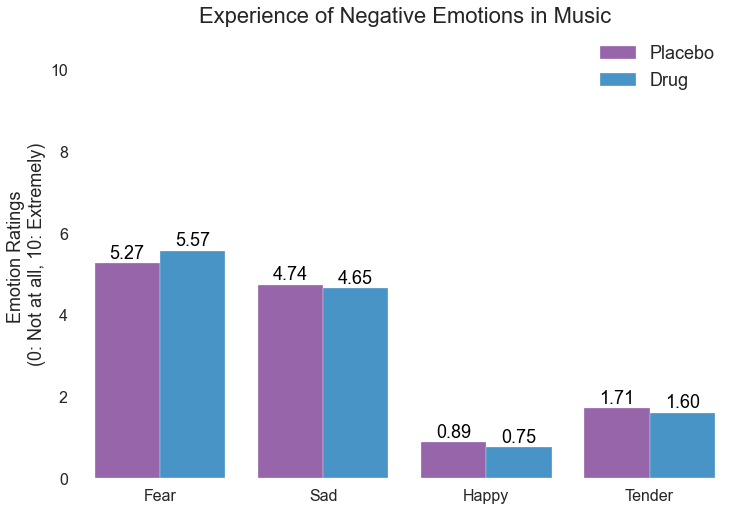

In [18]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Human*

In [19]:
human = natural[natural['Stimulus'].isin(['Neutral Human', 
                                             'Negative-Valence High-Arousal Human', 
                                             'Negative-Valence Low-Arousal Human', 
                                             'Positive-Valence High-Arousal Human', 
                                             'Positive-Valence Low-Arousal Human'])]

human['Stimulus'].replace("Neutral Human", "Neutral", inplace=True)
human['Stimulus'].replace("Negative-Valence High-Arousal Human", "NV-HA", inplace=True)
human['Stimulus'].replace("Negative-Valence Low-Arousal Human", "NV-LA", inplace=True)
human['Stimulus'].replace("Positive-Valence High-Arousal Human", "PV-HA", inplace=True)
human['Stimulus'].replace("Positive-Valence Low-Arousal Human", "PV-LA", inplace=True)

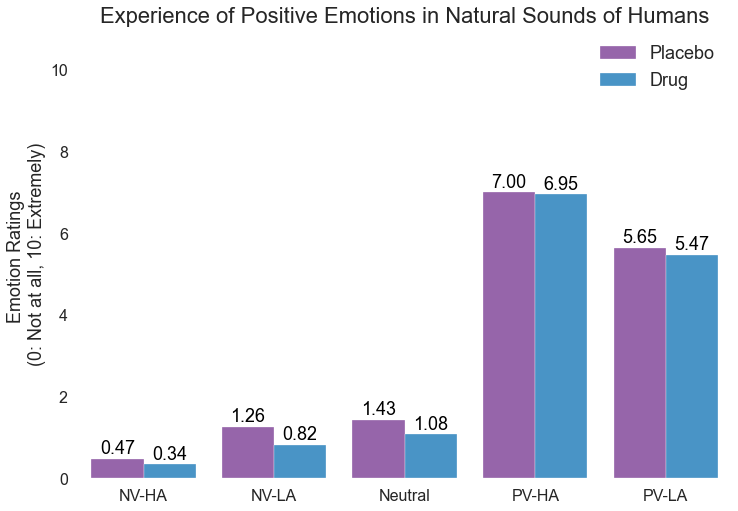

In [20]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

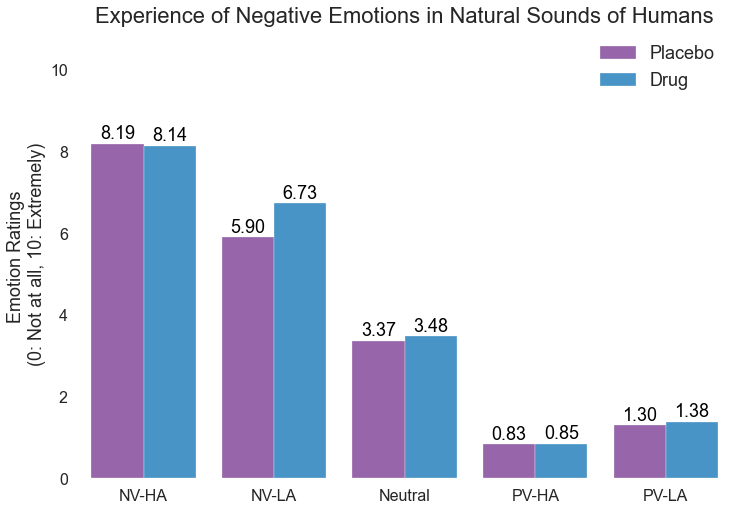

In [21]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Non-Human*

In [22]:
nonhuman = natural[natural['Stimulus'].isin(['Neutral Non-human', 
                                             'Negative-Valence High-Arousal Non-human', 
                                             'Negative-Valence Low-Arousal Non-human', 
                                             'Positive-Valence High-Arousal Non-human', 
                                             'Positive-Valence Low-Arousal Non-human'])]

nonhuman['Stimulus'].replace("Neutral Non-human", "Neutral", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence High-Arousal Non-human", "NV-HA", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence Low-Arousal Non-human", "NV-LA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence High-Arousal Non-human", "PV-HA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence Low-Arousal Non-human", "PV-LA", inplace=True)

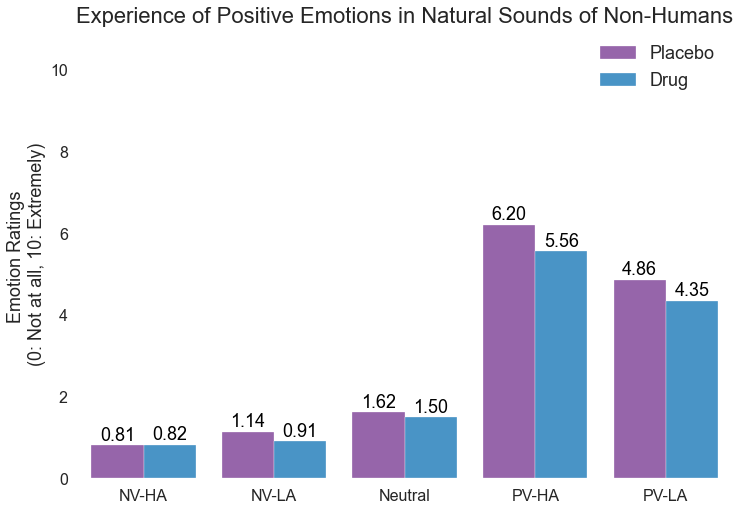

In [23]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

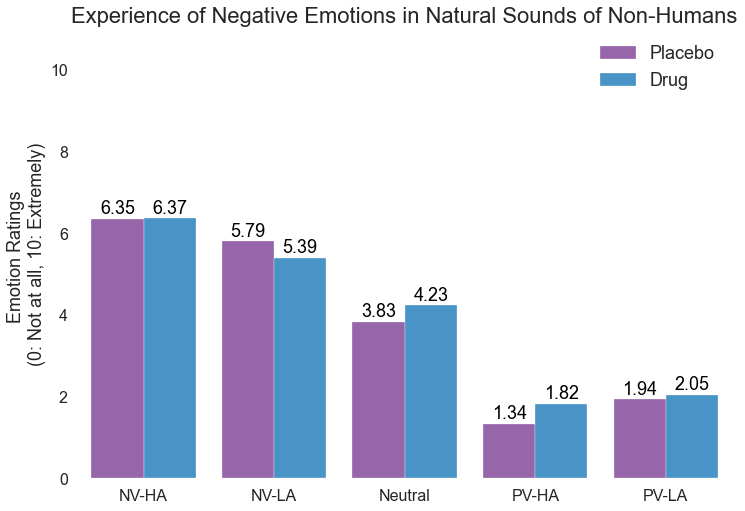

In [24]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

# Summary
**There did not seem to be any significant differences in *induced* emotion ratings in drug vs. placebo conditions.**

Before examining *perceived* emotions, we'll clean up the data and look at the pandas Profile Report.

In [25]:
# change columns back
inducedLong['DrugPlacebo'].replace("Placebo", 0, inplace=True)
inducedLong['DrugPlacebo'].replace("Drug", 1, inplace=True)
inducedLong['Russell'].replace("NV-HA", "Neg-Valence High-Arousal", inplace=True)
inducedLong['Russell'].replace("PV-HA", "Pos-Valence High-Arousal", inplace=True)
inducedLong['Russell'].replace("NV-LA", "Neg-Valence Low-Arousal", inplace=True)
inducedLong['Russell'].replace("PV-LA", "Pos-Valence Low-Arousal", inplace=True)

inducedLong.head(2)

,FixedID,DrugCode,DrugPlacebo,Locus,Stimulus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,PosNeg,SoundType,Russell
5,7.0,7J,0,Induced,Fear Music 1,8.0,0.0,Not Measured,1.0,0,2,0,0,1,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,2,2,0,Negative,Music,Neg-Valence High-Arousal
6,9.0,9J,0,Induced,Fear Music 1,4.0,6.0,Not Measured,1.0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Negative,Music,Neg-Valence High-Arousal


# Write out csv.

In [26]:
inducedLong.to_csv('inducedLong.csv', index=False)